In [4]:
import torch
from datasets import Features, Value, load_dataset, Sequence
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, Trainer, TrainingArguments, EvalPrediction
from fuzzywuzzy import fuzz
import re
import os
from dotenv import load_dotenv
import logging
import time
from adapters import AutoAdapterModel, AdapterTrainer, LlamaAdapterModel
import sys
import pandas as pd
import itertools
import gc

logging.basicConfig(level=logging.INFO)
load_dotenv()

ACCESS_TOKEN = os.getenv("HUGGINGFACE_API_KEY")
MODEL_DIR = os.getcwd() + "/models"
MODEL_ID = "meta-llama/Llama-3.1-8B-Instruct"
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
DATASET_DIR = os.getenv("DATASET_DIR") + "FinQA/dataset/"
RESULTS_DIR = os.getenv("RESULTS_DIR") + "FinQA/"
SIMILARITY_THRESHOLD = 85  
RESULTS_HEADER = ["model", "experiment", "trained_samples", "epochs", "batch_size", "evaluated_samples", "accuracy", "avg_similarity", "total_time", "avg_time_per_sample", "training_time"]
# Other possible headers: "similarity_threshold", "max_new_tokens", etc.

EXPERIMENT = "adapter" # "adapter" or "baseline"

def preprocess_to_finetune(batch):
    prompt = batch["input_text"]
    answer = batch["expected_answer"]
    full_text = [p+a for p, a in zip(prompt, answer)]


    full_text_encodings = tokenizer(full_text, return_tensors="pt", padding=True, truncation=True)

    prompt_encodings = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    prompt_len = prompt_encodings["input_ids"].shape[1] # One length is enough if padding + truncation

    labels = full_text_encodings["input_ids"].clone()
    labels[:, :prompt_len] = -100 # Ignore loss on prompt tokens?

    full_text_encodings["labels"] = labels # Tokenized_full has input_ids, attention_mask, labels

    return  full_text_encodings
    # encoded = tokenizer(batch["input_text"], truncation=True, padding=True)
    # return  encoded
    
def load_model(model_id, device, token, cache_dir):
    logging.info(f"Loading model {model_id} on device {device}")
    # Define 4-bit quantization configuration
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,  # Enable 4-bit quantization
        bnb_4bit_compute_dtype=torch.float16,  # Use FP16 for computation
        bnb_4bit_use_double_quant=True,  # Double quantization for better memory efficiency
        bnb_4bit_quant_type="nf4"  # NormalFloat4, best for Llama models
    )
    # Load tokenizer and model
    if EXPERIMENT == "adapter":
        model = LlamaAdapterModel.from_pretrained(
            model_id,
            device_map={"": device},
            quantization_config=quant_config,
            cache_dir=cache_dir,
            torch_dtype=torch.bfloat16,
        )
        model.gradient_checkpointing_enable()  # Enable gradient checkpointing
    elif EXPERIMENT == "baseline":
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map={"": device},
            quantization_config=quant_config,
            cache_dir=cache_dir,
            torch_dtype=torch.bfloat16,
        )
    else:
        raise ValueError(f"Unknown experiment type thus can't decide model: {EXPERIMENT}")
    
    tokenizer = AutoTokenizer.from_pretrained(
        model_id, 
        token=token,
        cache_dir=cache_dir
    )

    tokenizer.pad_token = tokenizer.eos_token # For padding in batch

    return model, tokenizer

def preprocess_function(example):
    # TODO: should raise error or warning when absent
    question = example["qa"].get("question", "No question available.")
    expected_answer = str(example['qa'].get("answer", "")).strip()
    table = example.get("table", [])
    table_str = "\n".join([" | ".join(row) for row in table])

    pre_text = " ".join(example.get("pre_text", []))
    post_text = " ".join(example.get("post_text", []))

    input_text = (
        "You are a financial calculator. Follow these steps:\n"
        "Return ONLY the final numerical or boolean answer with no text explanation\n\n"
        f"Pre Text Data:\n{pre_text}\n\n"
        f"Table Data:\n{table_str}\n\n"
        f"Post Text Data:\n{post_text}\n\n"
        f"Question: {question}\n"
        "Final Answer (number only): "
    )

    return {
        "input_text": input_text,
        "expected_answer": expected_answer
    }

def load_preprocessed_dataset(path: str, data_files: str, split: str):
    logging.info("Loading dataset")
    dataset = load_dataset(
        path,
        data_files=data_files,
        split=split
    )

    logging.info("Preprocessing dataset")
    dataset = dataset.map(preprocess_function, remove_columns=dataset.column_names)
    dataset = dataset.with_format("torch")  # Use lazy loading
    return dataset

def generate_answer(input_text, tokenizer: AutoTokenizer, model: AutoModelForCausalLM):
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True).to(DEVICE)
    input_ids = inputs["input_ids"]

    with torch.no_grad():
        outputs = model.generate(**inputs, temperature=0.1, top_k=10, max_new_tokens=20, pad_token_id=tokenizer.eos_token_id)
    generated_text = tokenizer.decode(outputs[:, input_ids.shape[-1]:][0], skip_special_tokens=True)

    return generated_text

def clean_answer(text):
    
    # TODO: Add more extracting logic here
    # Extract only the answer part from generated text
    if "Answer:" in text:
        text = text.split("Answer:")[-1].strip()

    # TODO: Add tolerance relative to the size of the number
    # Handle percentage
    percent_match = re.search(r'[-+]?\d*\.?\d+\s*%', text)
    if percent_match:
        number = float(percent_match.group(0).replace('%', '').strip())
        return f"{round(number, 0)}%"

    # TODO: Add tolerance relative to the size of the number
    # Handle regular numbers
    decimal_match = re.search(r'[-+]?\d*\.?\d+', text, re.MULTILINE)
    if decimal_match:
        number = float(decimal_match.group(0))
        # If it's close to an integer, round it
        if abs(round(number) - number) < 0.01:
            return str(round(number))
        # Otherwise, round to one decimal place
        return str(round(number, 0))

    # Handle yes/no answers
    text = text.lower().strip()
    if 'yes' in text or 'true' in text:
        return 'yes'
    if 'no' in text or 'false' in text:
        return 'no'

    return text.strip()


    

/cs/student/projects1/aibh/2024/lqiulin/EmpiriNLP/FrugalML/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


# Inspect input length

In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID, 
    cache_dir=MODEL_DIR,
)
tokenizer.pad_token = tokenizer.eos_token # For padding in batch

train_dataset = load_preprocessed_dataset("json", data_files=DATASET_DIR+"/train.cleaned.json", split="train")
train_dataset = train_dataset.map(preprocess_to_finetune, batched=True, batch_size=1)
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"], device=DEVICE) 

val_dataset = load_preprocessed_dataset("json", data_files=DATASET_DIR+"/dev.cleaned.json", split="train")
val_dataset = val_dataset.map(preprocess_to_finetune, batched=True, batch_size=1)
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"], device=DEVICE) 

test_dataset = load_preprocessed_dataset("json", data_files=DATASET_DIR+"/test.cleaned.json", split="train")
test_dataset = test_dataset.map(preprocess_to_finetune, batched=True, batch_size=1)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"], device=DEVICE) 

INFO:root:Loading dataset
INFO:root:Preprocessing dataset
INFO:root:Loading dataset
INFO:root:Preprocessing dataset
INFO:root:Loading dataset
INFO:root:Preprocessing dataset


6203
871
1133


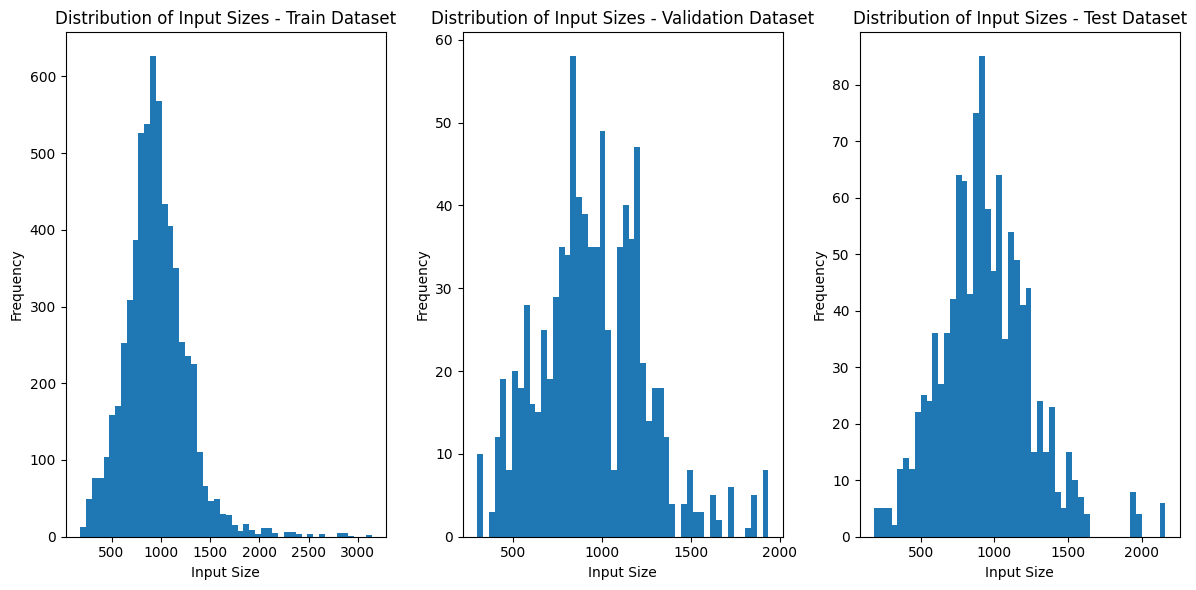

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
for i, dataset_split in enumerate([train_dataset, val_dataset, test_dataset]):
    input_sizes = [len(dataset_split[i]["input_ids"]) for i in range(len(dataset_split))]
    ax[i].hist(input_sizes, bins=50)
    ax[i].set_xlabel("Input Size")
    ax[i].set_ylabel("Frequency")
    ax[i].set_title(f"Distribution of Input Sizes - {['Train', 'Validation', 'Test'][i]} Dataset")
    print(len(input_sizes))
plt.tight_layout()
plt.show()


In [14]:
token_id = 19391
tokenizer.decode(token_id)

'419'

# Experiment results analysis

In [ ]:
import pandas as pd
import json, os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_palette("Set2")

df = pd.read_csv("./results/FinQA/results.tsv", sep="\t")

# Parse json files and add flos
for filename in os.listdir("./results/FinQA/"):
    if filename.endswith(".json"):
        filename_fields = filename[7:-5].split("-")
        if "_" not in filename_fields[-1]:
            filename_fields[-2] = filename_fields[-2] + "-" + filename_fields[-1]
            filename_fields.pop()
        fields = {field.split("_")[0]:field.split("_")[1] for field in filename_fields}
        fields["lr"] = float(fields["lr"])
        fields["bs"] = int(fields["bs"])
        fields["ts"] = int(fields["ts"])
        
        with open(os.path.join("./results/FinQA/", filename), 'r') as f:
            data = json.load(f)
            flos = data["total_flos"]
            df.loc[(df["trained_samples"]==fields["ts"])
                   & (df["batch_size"]==fields["bs"])
                   & (df["learning_rate"]==fields["lr"]), "flos"] = flos
            
display(df[["experiment", "epochs", "trained_samples", "batch_size", "learning_rate", "accuracy", "avg_similarity", "training_time", "flos"]])

,experiment,epochs,trained_samples,batch_size,learning_rate,accuracy,avg_similarity,training_time,flos
0,baseline,0,0,0,0.00000,39.10,70.69,0.0000,NaN
1,adapter,15,50,1,0.00010,6.71,54.02,1649.8280,1.010434e+16
2,adapter,15,50,1,0.00010,10.59,55.26,1407.3950,1.010434e+16
3,adapter,15,50,1,0.00003,7.50,53.98,1481.0996,1.616695e+16
4,adapter,15,50,1,0.00100,0.00,10.87,1469.8407,2.425042e+16
5,adapter,15,50,2,0.00010,8.12,54.56,1630.9404,1.134675e+16
6,adapter,15,50,2,0.00003,4.06,52.82,1496.2560,1.815480e+16
7,adapter,15,50,2,0.00100,0.00,0.00,1532.3025,2.042416e+16
8,adapter,15,50,4,0.00010,10.06,55.14,1935.7656,1.268365e+16
9,adapter,15,50,4,0.00003,1.15,50.62,1701.5548,1.014692e+16


C:\Users\lifeng\AppData\Local\Temp\ipykernel_56708\1112422536.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="learning_rate", y="accuracy", data=experiments_df, palette="Set2")


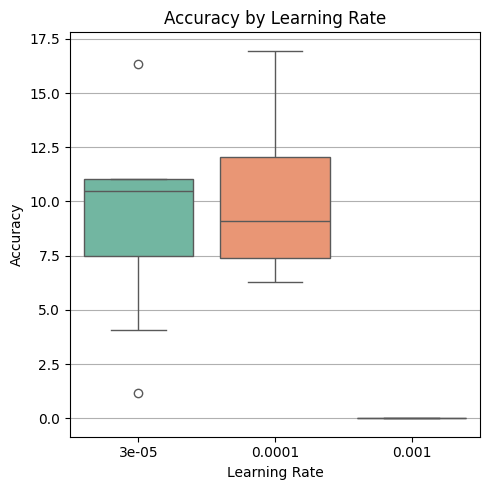

In [39]:
# Plot by learning rate
experiments_df = df[df["experiment"] == "adapter"]

plt.figure(figsize=(5, 5))
sns.boxplot(x="learning_rate", y="accuracy", data=experiments_df, palette="Set2")
plt.title("Accuracy by Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("imgs/accuracy_by_learning_rate.png")
plt.show()

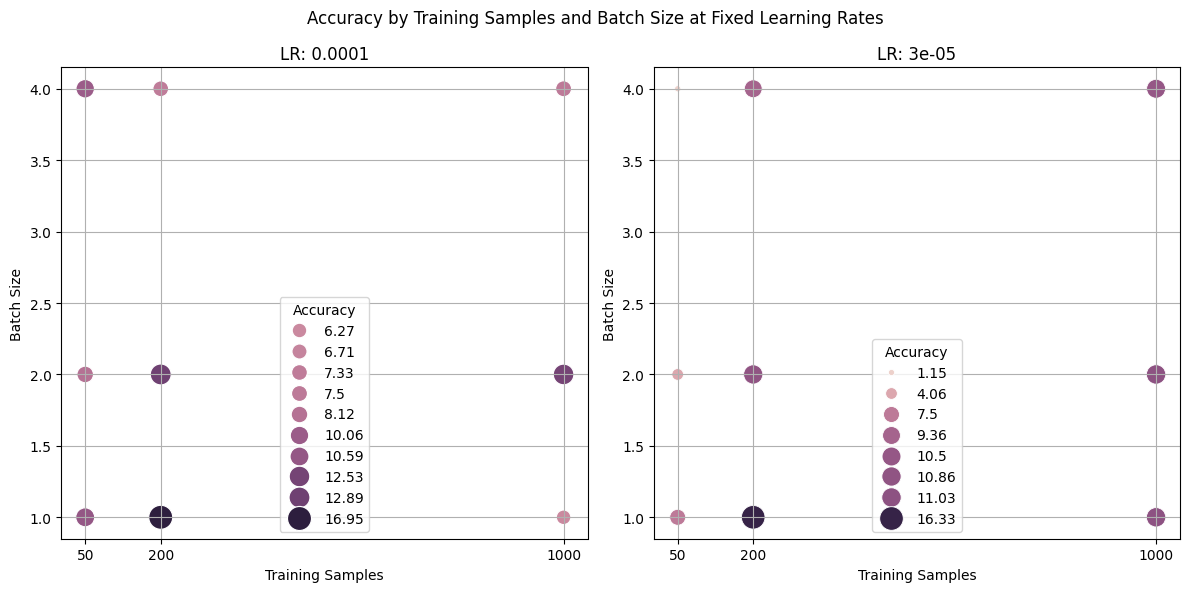

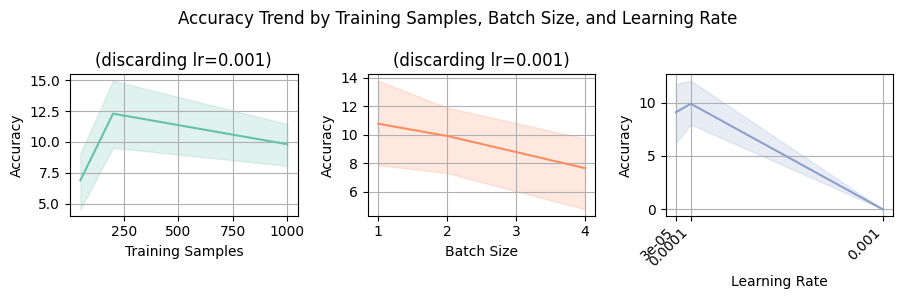

In [178]:
# Plot tendency of accuracy by training samples and batch size, fixing learning rate
experiments_df = df[df["experiment"] == "adapter"]

# Scatter plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
norm = (experiments_df[experiments_df["accuracy"] != 0]["accuracy"].min(), experiments_df[experiments_df["accuracy"] != 0]["accuracy"].max())
for i, lr in enumerate(experiments_df["learning_rate"].unique()):
    if lr == 0.001:
        continue
    lr_df = experiments_df[experiments_df["learning_rate"] == lr].copy()
    sns.scatterplot(data=lr_df, x="trained_samples", y="batch_size", hue="accuracy", size="accuracy", sizes=(20, 300), size_norm=norm, hue_norm=norm, ax=ax[i], legend="full")
    ax[i].set_title(f"LR: {lr}")
    ax[i].set_xlabel("Training Samples")
    ax[i].set_ylabel("Batch Size")
    # Show 50, 200, and 1000 in x-axis
    ax[i].set_xticks([50, 200, 1000])
    ax[i].set_xticklabels([50, 200, 1000])
    ax[i].legend(title="Accuracy")
    ax[i].grid()

plt.suptitle("Accuracy by Training Samples and Batch Size at Fixed Learning Rates")
plt.tight_layout()
plt.savefig("imgs/scatter_accuracy_trend.png")
plt.show()

# Line plot
non_zero_df = experiments_df[experiments_df["learning_rate"] != 0.001]
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
sns.lineplot(x="trained_samples", y="accuracy", data=non_zero_df, ax=ax[0], color="C0")
ax[0].set_title("(discarding lr=0.001)")
ax[0].set_xlabel("Training Samples")
ax[i].set_xticks([50, 200, 1000])
ax[i].set_xticklabels([50, 200, 1000])
ax[0].set_ylabel("Accuracy")
ax[0].grid()
sns.lineplot(x="batch_size", y="accuracy", data=non_zero_df, ax=ax[1], color="C1")
ax[1].set_title("(discarding lr=0.001)")
ax[1].set_xlabel("Batch Size")
ax[i].set_xticks([1, 2, 4])
ax[i].set_xticklabels([1, 2, 4])
ax[1].set_ylabel("Accuracy")
ax[1].grid()
sns.lineplot(x="learning_rate", y="accuracy", data=experiments_df, ax=ax[2], color="C2")
# ax[2].set_title("Accuracy by Learning Rate")
ax[2].set_xlabel("Learning Rate")
ax[i].set_xticks([0.001, 0.0001, 0.00003])
ax[i].set_xticklabels([0.001, 0.0001, 0.00003], rotation=45, ha="right")
ax[2].set_ylabel("Accuracy")
ax[2].grid()

plt.suptitle("Accuracy Trend by Training Samples, Batch Size, and Learning Rate")
plt.tight_layout()
plt.savefig("imgs/line_accuracy_trend.png")
plt.show()

C:\Users\lifeng\AppData\Local\Temp\ipykernel_56708\603424083.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="learning_rate", y="accuracy", data=experiments_df, palette="Set2", ax=axes[0, 0])


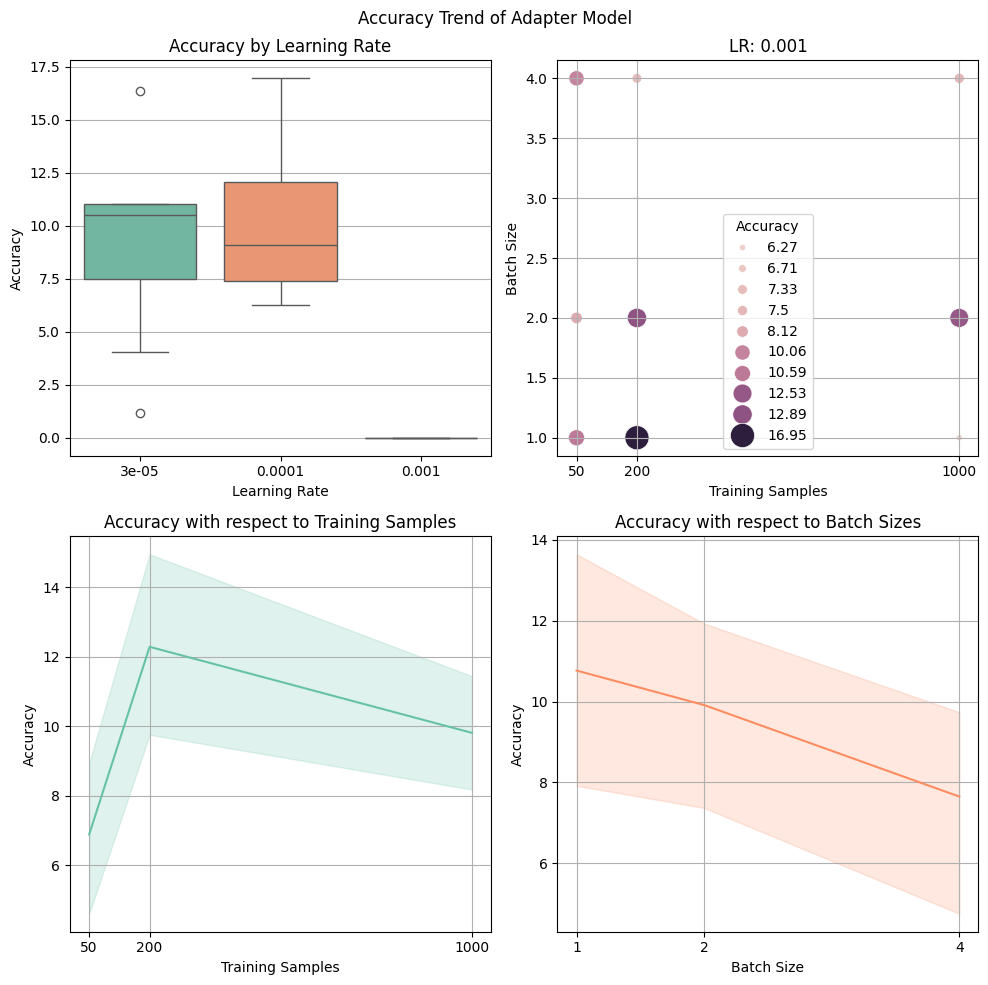

In [206]:
experiments_df = df[df["experiment"] == "adapter"]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.boxplot(x="learning_rate", y="accuracy", data=experiments_df, palette="Set2", ax=axes[0, 0])
axes[0, 0].set_title("Accuracy by Learning Rate")
axes[0, 0].set_xlabel("Learning Rate")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].grid(axis='y')


lr_df = experiments_df[experiments_df["learning_rate"] == 0.0001].copy()
sns.scatterplot(data=lr_df, x="trained_samples", y="batch_size", hue="accuracy", size="accuracy", sizes=(20, 300), ax=axes[0, 1], legend="full")
axes[0, 1].set_title(f"LR: {lr}")
axes[0, 1].set_xlabel("Training Samples")
axes[0, 1].set_ylabel("Batch Size")
# Show 50, 200, and 1000 in x-axis
axes[0, 1].set_xticks([50, 200, 1000])
axes[0, 1].set_xticklabels([50, 200, 1000])
axes[0, 1].legend(title="Accuracy")
axes[0, 1].grid()


non_zero_df = experiments_df[experiments_df["learning_rate"] != 0.001]
sns.lineplot(x="trained_samples", y="accuracy", data=non_zero_df, ax=axes[1, 0], color="C0")
axes[1, 0].set_title("Accuracy with respect to Training Samples")
axes[1, 0].set_xlabel("Training Samples")
axes[1, 0].set_xticks([50, 200, 1000])
axes[1, 0].set_xticklabels([50, 200, 1000])
axes[1, 0].set_ylabel("Accuracy")
axes[1, 0].grid()
sns.lineplot(x="batch_size", y="accuracy", data=non_zero_df, ax=axes[1, 1], color="C1")
axes[1, 1].set_title("Accuracy with respect to Batch Sizes")
axes[1, 1].set_xlabel("Batch Size")
axes[1, 1].set_xticks([1, 2, 4])
axes[1, 1].set_xticklabels([1, 2, 4])
axes[1, 1].set_ylabel("Accuracy")
axes[1, 1].grid()

plt.suptitle("Accuracy Trend of Adapter Model")
plt.tight_layout()
plt.savefig("imgs/accuracy_trend_adapter.png")
plt.show()

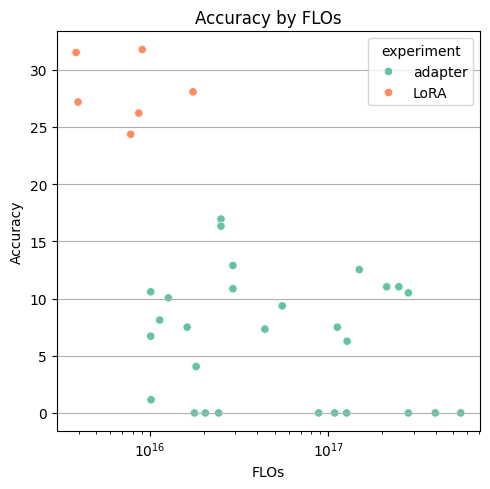

In [203]:
# Plot accuracy against flos
experiments_df = df[df["experiment"] == "adapter"]

extra_experiments_df = experiments_df.copy()

accuracy_b1 = [27.18, 31.51, 24.36]
flop_b1_epoch = [3955595402013639,  7816036752517956, 11665234227612228]
accuracy_b2 = [26.21, 31.77, 28.07]
flop_b2_epoch = [8667043722857328, 17722287754259724, 26486072898851250]

prev = 0
for accuracy, flos in zip(accuracy_b1, flop_b1_epoch):
    flos = flos - prev
    prev = flos
    extra_experiments_df = pd.concat([extra_experiments_df, pd.DataFrame({"accuracy": accuracy, "flos": flos, "experiment": "LoRA"}, index=[0])], ignore_index=True)
prev = 0
for accuracy, flos in zip(accuracy_b2, flop_b2_epoch):
    flos = flos - prev
    prev = flos
    extra_experiments_df = pd.concat([extra_experiments_df, pd.DataFrame({"accuracy": accuracy, "flos": flos, "experiment": "LoRA"}, index=[0])], ignore_index=True)

plt.figure(figsize=(5, 5))
sns.scatterplot(x="flos", y="accuracy", data=extra_experiments_df, palette="Set2", hue="experiment")
plt.title("Accuracy by FLOs")
plt.xlabel("FLOs")
plt.ylabel("Accuracy")
plt.xscale('log')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("imgs/accuracy_by_flos.png")
plt.show()

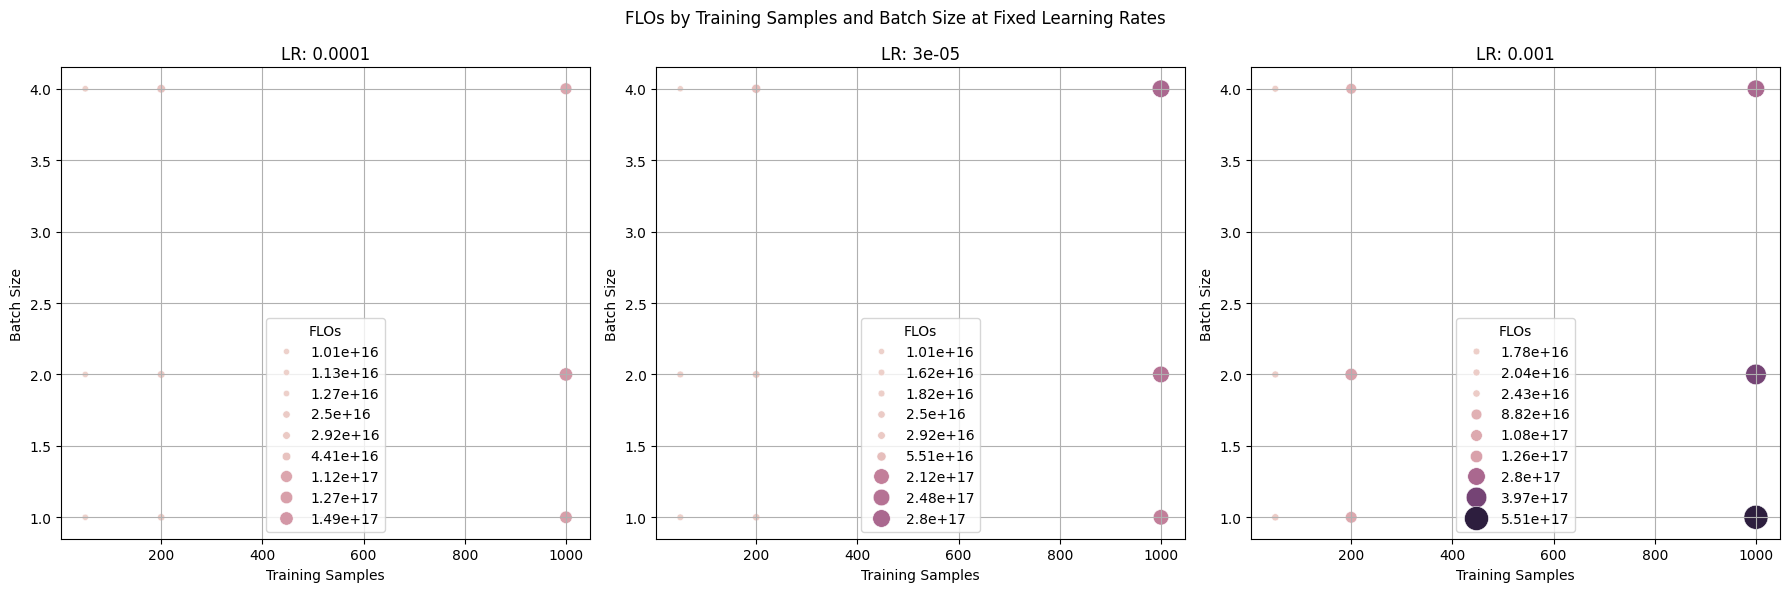

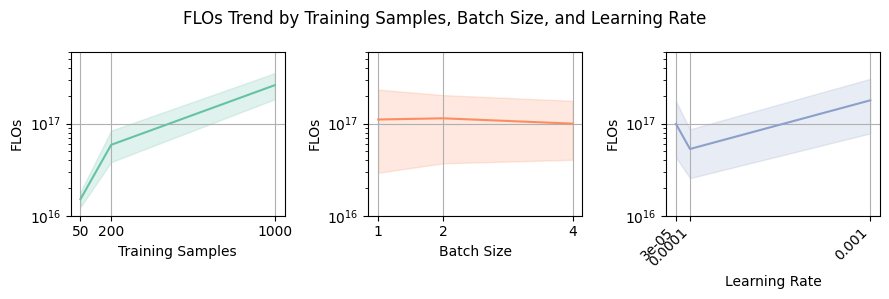

In [179]:
# Plot tendency of flos by training samples and batch size, fixing learning rate
experiments_df = df[df["experiment"] == "adapter"]
formatted_flos_df = experiments_df.copy()
formatted_flos_df["flos"] = formatted_flos_df["flos"].apply(lambda x: float("{:.2e}".format(x)))


# Scatter plot
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
norm = (formatted_flos_df["flos"].min(), formatted_flos_df["flos"].max())
for i, lr in enumerate(formatted_flos_df["learning_rate"].unique()):
    lr_df = formatted_flos_df[formatted_flos_df["learning_rate"] == lr].copy()
    sns.scatterplot(data=lr_df, x="trained_samples", y="batch_size", hue="flos", size="flos", sizes=(20, 300), size_norm=norm, hue_norm=norm, ax=ax[i], legend="full")
    ax[i].set_title(f"LR: {lr}")
    ax[i].set_xlabel("Training Samples")
    ax[i].set_ylabel("Batch Size")
    # Show 50, 200, and 1000 in x-axis
    # ax[i].set_xticks([50, 200, 1000])
    # ax[i].set_xticklabels([50, 200, 1000])

    # Format legend to two decimal places
    # handles, labels = ax[i].get_legend_handles_labels()
    # new_labels = []
    # for label in labels:
    #     new_labels.append(f"{float(label):.2e}")

    # ax[i].legend(handles, new_labels, title="FLOs")

    ax[i].legend(title="FLOs")
    ax[i].grid()

plt.suptitle("FLOs by Training Samples and Batch Size at Fixed Learning Rates")
plt.tight_layout()
plt.savefig("imgs/scatter_flos_trend.png")
plt.show()

# Line plot
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
sns.lineplot(x="trained_samples", y="flos", data=formatted_flos_df, ax=ax[0], color="C0")
ax[0].set_xlabel("Training Samples")
ax[0].set_xticks([50, 200, 1000])
ax[0].set_xticklabels([50, 200, 1000])
ax[0].set_yscale('log')
ax[0].set_ylim(1e16, 6e17)
ax[0].set_ylabel("FLOs")
ax[0].grid()
sns.lineplot(x="batch_size", y="flos", data=formatted_flos_df, ax=ax[1], color="C1")
ax[1].set_xlabel("Batch Size")
ax[1].set_xticks([1, 2, 4])
ax[1].set_xticklabels([1, 2, 4])
ax[1].set_yscale('log')
ax[1].set_ylim(1e16, 6e17)
ax[1].set_ylabel("FLOs")
ax[1].grid()
sns.lineplot(x="learning_rate", y="flos", data=formatted_flos_df, ax=ax[2], color="C2")
ax[2].set_xlabel("Learning Rate")
ax[2].set_xticks([0.001, 0.0001, 0.00003])
ax[2].set_xticklabels([0.001, 0.0001, 0.00003], rotation=45, ha="right")
ax[2].set_yscale('log')
ax[2].set_ylim(1e16, 6e17)
ax[2].set_ylabel("FLOs")
ax[2].grid()

plt.suptitle("FLOs Trend by Training Samples, Batch Size, and Learning Rate")
plt.tight_layout()
plt.savefig("imgs/line_flos_trend.png")
plt.show()

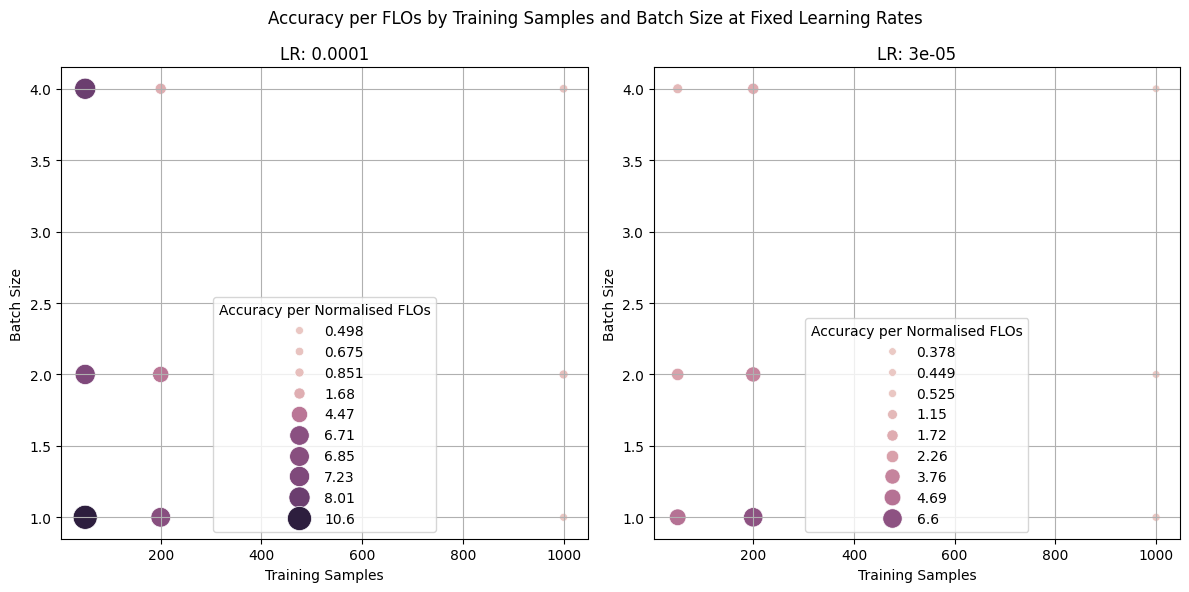

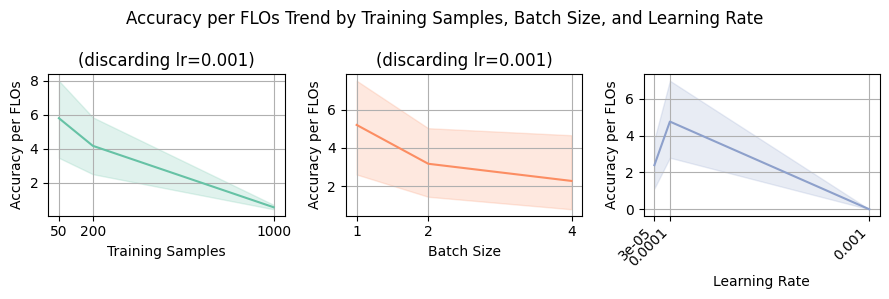

In [210]:
# Plot tendency of flos by training samples and batch size, fixing learning rate
experiments_df = df[df["experiment"] == "adapter"]
accuracy_per_flos_df = experiments_df.copy()
# accuracy_per_flos_df["accuracy_per_flos"] = accuracy_per_flos_df["accuracy"] / accuracy_per_flos_df["flos"]
accuracy_per_flos_df["accuracy_per_flos"] = accuracy_per_flos_df["accuracy"] / (accuracy_per_flos_df["flos"] / accuracy_per_flos_df["flos"].min())
accuracy_per_flos_df["accuracy_per_flos"] = accuracy_per_flos_df["accuracy_per_flos"].apply(lambda x: float("{:.2e}".format(x)))


# Scatter plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
norm = (accuracy_per_flos_df["accuracy_per_flos"].min(), accuracy_per_flos_df["accuracy_per_flos"].max())
for i, lr in enumerate(accuracy_per_flos_df["learning_rate"].unique()):
    if lr == 0.001:
        continue
    lr_df = accuracy_per_flos_df[accuracy_per_flos_df["learning_rate"] == lr].copy()
    sns.scatterplot(data=lr_df, x="trained_samples", y="batch_size", hue="accuracy_per_flos", size="accuracy_per_flos", sizes=(20, 300), size_norm=norm, hue_norm=norm, ax=ax[i], legend="full")
    ax[i].set_title(f"LR: {lr}")
    ax[i].set_xlabel("Training Samples")
    ax[i].set_ylabel("Batch Size")
    # Show 50, 200, and 1000 in x-axis
    # ax[i].set_xticks([50, 200, 1000])
    # ax[i].set_xticklabels([50, 200, 1000])

    # Format legend to two decimal places
    # handles, labels = ax[i].get_legend_handles_labels()
    # new_labels = []
    # for label in labels:
    #     new_labels.append(f"{float(label):.2e}")

    # ax[i].legend(handles, new_labels, title="FLOs")

    ax[i].legend(title="Accuracy per Normalised FLOs")
    ax[i].grid()

plt.suptitle("Accuracy per FLOs by Training Samples and Batch Size at Fixed Learning Rates")
plt.tight_layout()
plt.savefig("imgs/scatter_accpflos_trend.png")
plt.show()

# Line plot
non_zero_df = accuracy_per_flos_df[accuracy_per_flos_df["learning_rate"] != 0.001]
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
sns.lineplot(x="trained_samples", y="accuracy_per_flos", data=non_zero_df, ax=ax[0], color="C0")
ax[0].set_title("(discarding lr=0.001)")
ax[0].set_xlabel("Training Samples")
ax[0].set_xticks([50, 200, 1000])
ax[0].set_xticklabels([50, 200, 1000])
# ax[0].set_yscale('log')
# ax[0].set_ylim(1e16, 6e17)
ax[0].set_ylabel("Accuracy per FLOs")
ax[0].grid()
sns.lineplot(x="batch_size", y="accuracy_per_flos", data=non_zero_df, ax=ax[1], color="C1")
ax[1].set_title("(discarding lr=0.001)")
ax[1].set_xlabel("Batch Size")
ax[1].set_xticks([1, 2, 4])
ax[1].set_xticklabels([1, 2, 4])
# ax[1].set_yscale('log')
# ax[1].set_ylim(1e16, 6e17)
ax[1].set_ylabel("Accuracy per FLOs")
ax[1].grid()
sns.lineplot(x="learning_rate", y="accuracy_per_flos", data=accuracy_per_flos_df, ax=ax[2], color="C2")
ax[2].set_xlabel("Learning Rate")
ax[2].set_xticks([0.001, 0.0001, 0.00003])
ax[2].set_xticklabels([0.001, 0.0001, 0.00003], rotation=45, ha="right")
# ax[2].set_yscale('log')
# ax[2].set_ylim(1e16, 6e17)
ax[2].set_ylabel("Accuracy per FLOs")
ax[2].grid()

plt.suptitle("Accuracy per FLOs Trend by Training Samples, Batch Size, and Learning Rate")
plt.tight_layout()
plt.savefig("imgs/line_accpflos_trend.png")
plt.show()

In [ ]:
# # Plot tendency of flos by training samples and batch size, fixing learning rate
# experiments_df = df[df["experiment"] == "adapter"]

# accuracy_per_flos_df = experiments_df.copy()
# # accuracy_per_flos_df["accuracy_per_flos"] = accuracy_per_flos_df["accuracy"] / accuracy_per_flos_df["flos"]
# accuracy_per_flos_df["accuracy_per_flos"] = accuracy_per_flos_df["accuracy"] / (accuracy_per_flos_df["flos"] / accuracy_per_flos_df["flos"].min())
# accuracy_per_flos_df["accuracy_per_flos"] = accuracy_per_flos_df["accuracy_per_flos"].apply(lambda x: float("{:.2e}".format(x)))

# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# # Scatter plot
# norm = (accuracy_per_flos_df["accuracy_per_flos"].min(), accuracy_per_flos_df["accuracy_per_flos"].max())
# for i, lr in enumerate(accuracy_per_flos_df["learning_rate"].unique()):
#     if lr == 0.001:
#         continue
#     lr_df = accuracy_per_flos_df[accuracy_per_flos_df["learning_rate"] == lr].copy()
#     sns.scatterplot(data=lr_df, x="trained_samples", y="batch_size", hue="accuracy_per_flos", size="accuracy_per_flos", sizes=(20, 300), size_norm=norm, hue_norm=norm, ax=axes[i], legend="full")
#     axes[i].set_title(f"LR: {lr}")
#     axes[i].set_xlabel("Training Samples")
#     axes[i].set_ylabel("Batch Size")
#     # Show 50, 200, and 1000 in x-axis
#     # ax[i].set_xticks([50, 200, 1000])
#     # ax[i].set_xticklabels([50, 200, 1000])

#     # Format legend to two decimal places
#     # handles, labels = ax[i].get_legend_handles_labels()
#     # new_labels = []
#     # for label in labels:
#     #     new_labels.append(f"{float(label):.2e}")

#     # ax[i].legend(handles, new_labels, title="FLOs")

#     axes[i].legend(title="Accuracy per Normalised FLOs")
#     axes[i].grid()

# plt.suptitle("Accuracy per Normalised FLOs by Training Samples and Batch Size at Fixed Learning Rates")
# plt.tight_layout()
# plt.savefig("imgs/scatter_accpflos_trend.png")


# sns.lineplot(x="trained_samples", y="flos", data=formatted_flos_df, ax=ax[0], color="C0")
# ax[0].set_xlabel("Training Samples")
# ax[0].set_xticks([50, 200, 1000])
# ax[0].set_xticklabels([50, 200, 1000])
# ax[0].set_yscale('log')
# ax[0].set_ylim(1e16, 6e17)
# ax[0].set_ylabel("FLOs")
# ax[0].grid()
# sns.lineplot(x="batch_size", y="flos", data=formatted_flos_df, ax=ax[1], color="C1")
# ax[1].set_xlabel("Batch Size")
# ax[1].set_xticks([1, 2, 4])
# ax[1].set_xticklabels([1, 2, 4])
# ax[1].set_yscale('log')
# ax[1].set_ylim(1e16, 6e17)
# ax[1].set_ylabel("FLOs")
# ax[1].grid()
# sns.lineplot(x="learning_rate", y="flos", data=formatted_flos_df, ax=ax[2], color="C2")
# ax[2].set_xlabel("Learning Rate")
# ax[2].set_xticks([0.001, 0.0001, 0.00003])
# ax[2].set_xticklabels([0.001, 0.0001, 0.00003], rotation=45, ha="right")
# ax[2].set_yscale('log')
# ax[2].set_ylim(1e16, 6e17)
# ax[2].set_ylabel("FLOs")
# ax[2].grid()

states.ts_1000-bs_1-lr_0.0001.json
303
3 3
states.ts_1000-bs_1-lr_0.001.json
1313
13 13
states.ts_1000-bs_1-lr_3e-05.json
505
5 5
states.ts_1000-bs_2-lr_0.0001.json
303
3 3
states.ts_1000-bs_2-lr_0.001.json
808
8 8
states.ts_1000-bs_2-lr_3e-05.json
505
5 5
states.ts_1000-bs_4-lr_0.0001.json
202
2 2
states.ts_1000-bs_4-lr_0.001.json
505
5 5
states.ts_1000-bs_4-lr_3e-05.json
505
5 5
states.ts_200-bs_1-lr_0.0001.json
63
3 3
states.ts_200-bs_1-lr_0.001.json
273
13 13
states.ts_200-bs_1-lr_3e-05.json
63
3 3
states.ts_200-bs_2-lr_0.0001.json
63
3 3
states.ts_200-bs_2-lr_0.001.json
273
13 13
states.ts_200-bs_2-lr_3e-05.json
63
3 3
states.ts_200-bs_4-lr_0.0001.json
84
4 4
states.ts_200-bs_4-lr_0.001.json
168
8 8
states.ts_200-bs_4-lr_3e-05.json
105
5 5
states.ts_50-bs_1-lr_0.0001.json
30
5 5
states.ts_50-bs_1-lr_0.001.json
72
12 12
states.ts_50-bs_1-lr_3e-05.json
48
8 8
states.ts_50-bs_2-lr_0.0001.json
30
5 5
states.ts_50-bs_2-lr_0.001.json
54
9 9
states.ts_50-bs_2-lr_3e-05.json
48
8 8
states.

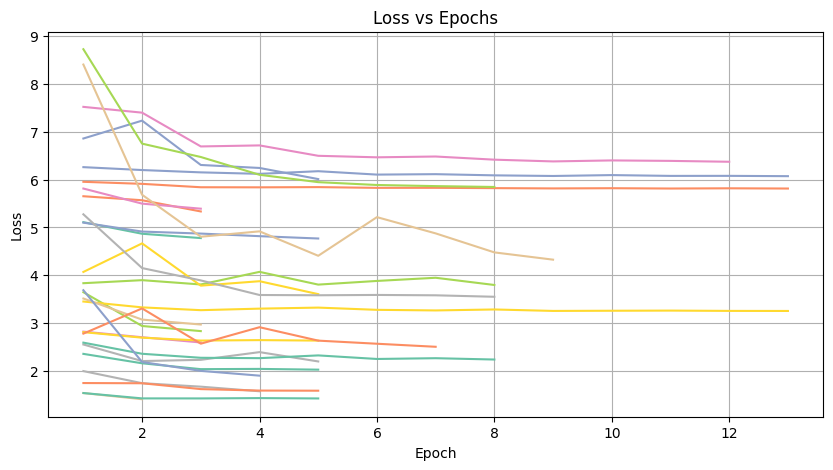

In [126]:
# Plot loss vs epochs
runs = []
for filename in os.listdir("./results/FinQA"):
    if filename.endswith(".json"):
        run = {"eval_loss": [], "epoch": []}
        with open(os.path.join("./results/FinQA/", filename), 'r') as f:
            data = json.load(f)
            print(filename)
            print(len(data["log_history"]))
            for history in data["log_history"]:
                if "eval_loss" in history.keys():
                    run["eval_loss"].append(history["eval_loss"])
                    run["epoch"].append(history["epoch"])
            assert len(run["epoch"]) == len(run["eval_loss"]), "Epoch and loss lengths do not match"
            print(len(run["epoch"]), len(run["eval_loss"]))
        runs.append(run)

# Plot loss vs epochs
plt.figure(figsize=(10, 5))
for run in runs:
    plt.plot(run["epoch"], run["eval_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.grid()


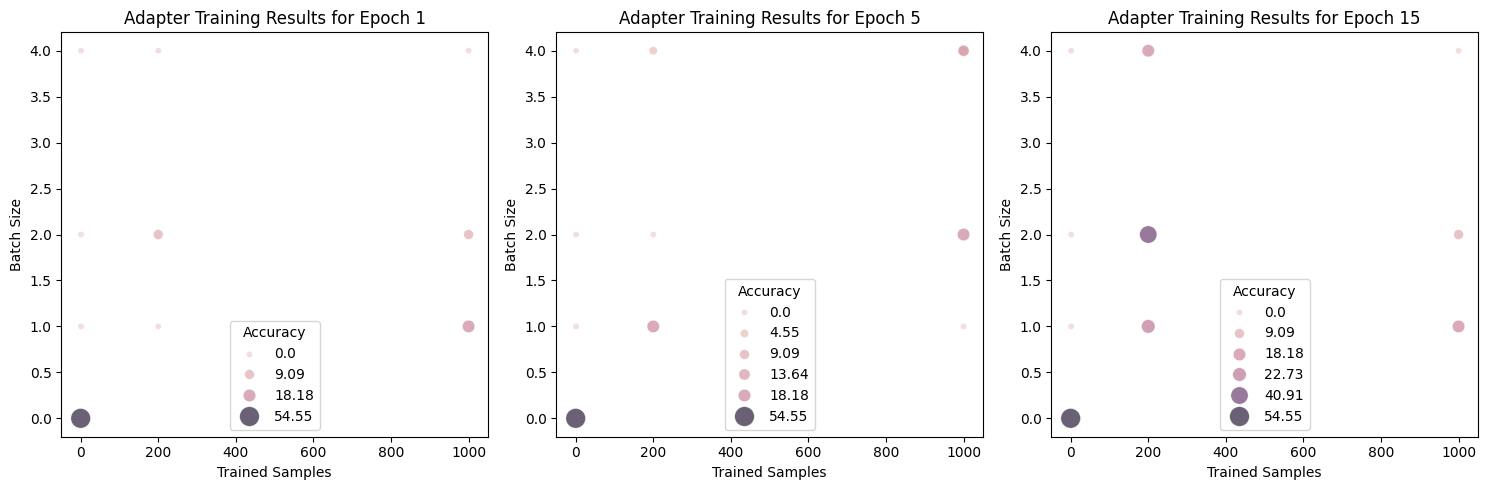

In [ ]:
# Visualise the results


experiments_df = df[df["experiment"] == "adapter"]

# visualise each epoch separately
fig, axes = plt.subplots(1, len(experiments_df["epochs"].unique()), figsize=(15, 5))
for i, epoch in enumerate(experiments_df["epochs"].unique()):
    epoch_df = pd.concat([experiments_df[experiments_df["epochs"] == epoch], df[df["experiment"] == "baseline"]])
    sns.scatterplot(data=epoch_df, x="trained_samples", y="batch_size", hue="accuracy", size="accuracy", sizes=(20, 200), ax=axes[i], alpha=0.7)
    axes[i].set_title(f"Adapter Training Results for Epoch {epoch}")
    axes[i].set_xlabel("Trained Samples")
    axes[i].set_ylabel("Batch Size")
    axes[i].legend(title="Accuracy")
plt.tight_layout()
plt.show()



# Inspect answer predictions

In [22]:
import os, json
for file in os.listdir("./results/FinQA/"):
    if file.endswith(".json"):
        print(file)
        with open(os.path.join("./results/FinQA/", file), "r") as f:
            data = json.load(f)
            for d in data:
                for key, value in d.items():
                    if key != "Question":
                        print(f"{key}: {value}")
        print("\n")

answers.epoch_15-ts_200-bs_2.json
Predicted Answer: 3.3%.3%.3%.3%.1%.3%.
Expected Answer: 380
Predicted Answer: 3.3%.3%.3%.3%.3%.3%.
Expected Answer: 
Predicted Answer: 3.3%.1%.3%.3%.3%.3%.
Expected Answer: 41932
Predicted Answer: 3.3%.3%.3%.3%.3%.3%.
Expected Answer: 53%
Predicted Answer: 3.3%.3%.3%.3%.3%.3%.
Expected Answer: -3.2%
Predicted Answer: 3.3%.3%.3%.3%.3%.3%.
Expected Answer: 56.25%
Predicted Answer: 3.3%.3%.3%.3%.3%.3%.
Expected Answer: 7.4
Predicted Answer: 3.3%.3%.3%.3%.3%.3%.
Expected Answer: 63.6%
Predicted Answer: 3.3%.1%.3%.3%.3%.3%.
Expected Answer: 96.55%
Predicted Answer: 3.3%.1%.3%.3%.3%.3%.
Expected Answer: 56.6
Predicted Answer: 3.3%.3%.3%.3%.3%.3%.
Expected Answer: 6.9
Predicted Answer: 3.3%.3%.3%.3%.3%.3%.
Expected Answer: 
Predicted Answer: 3.3%.3%.1%.3%.3%.1%.
Expected Answer: 65.3%
Predicted Answer: 3.3%.3%.3%.3%.3%.3%.
Expected Answer: 0.3%
Predicted Answer: 3.3%.1%.3%.3%.3%.3%.
Expected Answer: 28%
Predicted Answer: 3.7%.3%.1%.3%.3%.3%.
Expected Answer: 